# Network Project

*By Daniel Deutsch, Joseé Lucas Barretto, Karim Jaber and Ziyad Bekkaoui*

In [155]:
import warnings

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pytrends import dailydata

In [ ]:
# Filter warnings
warnings.filterwarnings('ignore')

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# Data Import

In [164]:
# Import the wikileaks dataset
df = pd.read_parquet('datasets/wikileaks.parquet')

# Import Google Trends Data
df_trends = dailydata.get_daily_data('wikileaks', start_year=2011, start_mon=1, stop_year=2022, stop_mon=1, geo='US', verbose=False, wait_time=0.1)

The request failed: Google returned a response with code 429.
Trying again in 60 seconds.


# Data Processing

In [166]:
# Process the Wikileaks dataframe
df['date'] = pd.to_datetime(df['time'], unit='s')
df = df[['hash', 'output_id', 'src', 'dst', 'value', 'time', 'nb_inputs', 'nb_outputs', 'fee', 'src_identity', 'dst_identity', 'PriceUSD', 'valueUSD', 'spent_timestamp', 'next_nb_inputs', 'dst_2', 'src_2', 'dst_cat', 'src_cat', 'year', 'month', 'day']]
df_trends.rename(columns={'PriceUSD': 'price_usd', 'valueUSD': 'value_usd'}, inplace=True)
df.sort_values(by='date', inplace=True)

# Process the Google Trends dataframe
df_trends = df_trends[['wikileaks_unscaled']]
df_trends = df_trends.reset_index()
df_trends.rename(columns={'wikileaks_unscaled': 'trend'}, inplace=True)

,hash,output_id,src,dst,value,time,nb_inputs,nb_outputs,fee,src_identity,...,valueUSD,spent_timestamp,next_nb_inputs,dst_2,src_2,dst_cat,src_cat,year,month,day
0,178e9457eab5c0a09653b1ce80a5dee3d5b2cd952c993c...,12,1FYvuAPFnFDXVeaysNhkTWQwA7wbhf34sQ,1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v,1000,1436520614,1,23,21500,None,...,0.003,1521993046,500.0,49240,None,None,None,2015,7,10
1,1821725e2b3e61d2ceea06bde32cb6dd475928281257c8...,12,1Bye3XXNaLhQG5oAQqPYbaiThbSp4YTHVA,1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v,1000,1436528402,1,23,21480,None,...,0.003,1521993831,500.0,49240,None,None,None,2015,7,10
2,4e81d13deda3df7198bc9c0f5d82a3ed5d3e1e09e87d59...,13,1MYkwSyGvtE4ztyPBNmuH4A2rZkzWj6y12,1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v,1000,1436526111,1,23,21500,None,...,0.003,1521993046,500.0,49240,None,None,None,2015,7,10
3,db6db7c8f7175945c4abdde1dc1113b4d22bd13bb7145b...,12,1AGhZjfSLhMgfXyVuHWm24PLAVFeqQ3np7,1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v,1000,1436501348,1,23,21480,None,...,0.003,1521992967,500.0,49240,None,None,None,2015,7,10
4,c24cdd5a7f68441c45aad9a424e7c5d16541c6ab2abc8e...,13,1JnZ4UNE7C86nYYwk2QSeC6kkrgvtkzEMD,1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v,1000,1436490711,1,23,21520,None,...,0.003,1521997285,500.0,49240,None,None,None,2015,7,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51872,adcd72aa43872d59a32944b47b88ab294aeaa46a7dca8f...,1,12oAxBxjkV8qjrbmevBANdnnPYhXHvt2ns,1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v,114664,1572686350,1,2,6641,0,...,10.664,1572686603,1.0,49240,0,None,None,2019,11,2
51873,6daa6f6525b41200f9a2dab86e9985ce6f329735489b88...,1,19AUWmJyeKr5QWVYfEx7SY5v2eJGkDScsp,1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v,108365,1524914637,1,2,11229,0,...,10.123,1524918174,2.0,49240,0,None,None,2018,4,28
51874,537a1f4e7a1ff317317bc398078cfcc28750d68dc8472e...,0,1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v,33wvNiUkXJAJ85e4yXJxJVWtsKqWDsDFK4,107359,1524918174,2,1,2006,49240,...,10.029,1546040167,39.0,72406474,49240,None,None,2018,4,28
51875,49af6300d8af79c1a52f281a01976f9a706fe9f334d999...,16,14qf2KCqCxDUQURnxkWmxgLCv225dMvMpf,1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v,100000,1442477824,1,20,43769,None,...,0.233,1479496938,47.0,49240,None,None,None,2015,9,17


# Donations to Wikileaks Over Time

In [ ]:
wikileaks_dsts = ['1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v', '1MaXZE92yjuy4NYjTspmdWHMRT3jQUcTf4']

In [124]:
wikileaks_dst = (df['dst'] == '1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v') |  (df['dst'] == '1MaXZE92yjuy4NYjTspmdWHMRT3jQUcTf4')
df_value_donations = df.loc[wikileaks_dst].groupby(df.loc[wikileaks_dst].loc[:, 'time'].dt.date).sum()[['valueUSD']]
df_count_donations = df.loc[wikileaks_dst].groupby(df.loc[wikileaks_dst].loc[:, 'time'].dt.date).count()[['valueUSD']]

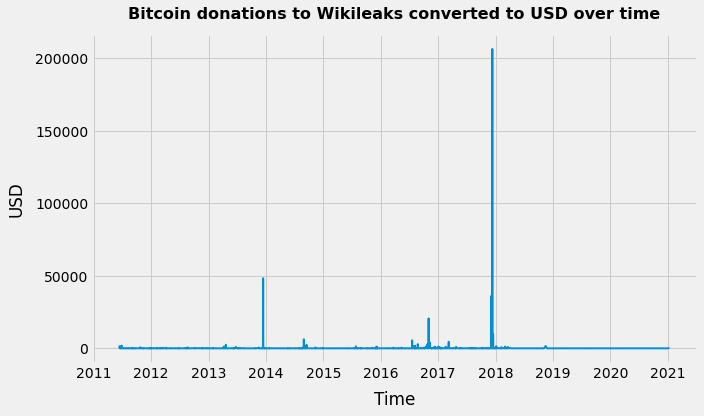

In [125]:
plt.figure()
plt.plot(df_value_donations.index, df_value_donations.valueUSD)
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Bitcoin donations to Wikileaks converted to USD over time')
plt.show()

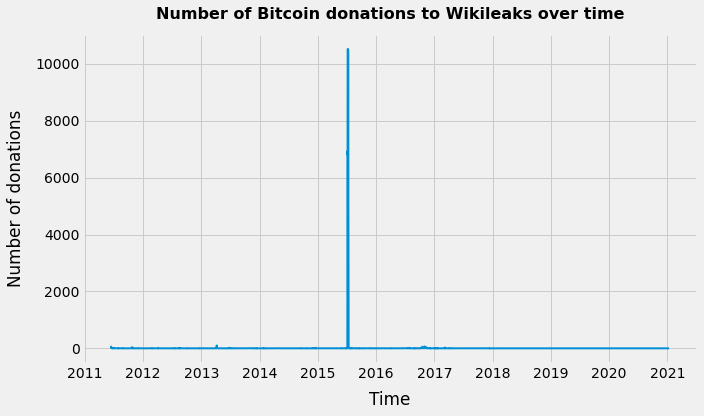

In [138]:
plt.figure()
plt.plot(df_count_donations.index, df_count_donations.valueUSD)
plt.ylabel('Number of donations')
plt.xlabel('Time')
plt.title('Number of Bitcoin donations to Wikileaks over time')
plt.show()

In [161]:
df_trends = dailydata.get_daily_data('wikileaks', 2011, 1, 2022, 1, wait_time=0.01, verbose=False)['wikileaks_unscaled']
df_trends = pd.merge(df_trends, df_count_donations, how='inner', right_index=True, left_index=True)

The request failed: Google returned a response with code 429.
Trying again in 60 seconds.


In [159]:
df

,wikileaks_unscaled,wikileaks_monthly,isPartial,scale,wikileaks
date,,,,,
2019-01-01,4,NaN,NaN,NaN,NaN
2019-01-02,5,NaN,NaN,NaN,NaN
2019-01-03,6,NaN,NaN,NaN,NaN
2019-01-04,6,NaN,NaN,NaN,NaN
2019-01-05,4,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2019-10-27,62,4.0,False,0.04,2.48
2019-10-28,65,4.0,NaN,0.04,2.60
2019-10-29,49,4.0,NaN,0.04,1.96


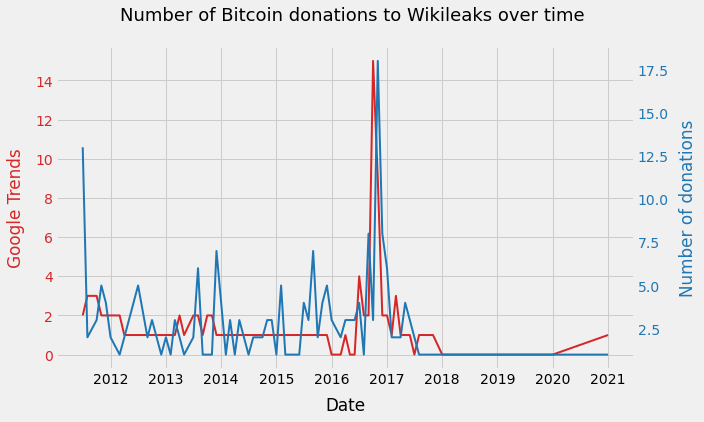

In [136]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Google Trends', color=color)
ax1.plot(df_trends.index, df_trends.wikileaks, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of donations', color=color)  # we already handled the x-label with ax1
ax2.plot(df_trends.index, df_trends.valueUSD, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False)

fig.suptitle('Number of Bitcoin donations to Wikileaks over time')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [137]:
df_trends.corr()

,wikileaks,valueUSD
wikileaks,1.000000,0.368832
valueUSD,0.368832,1.000000


In [ ]:
plt.figure()
plt.plot(df_count_donations.index, df_count_donations.valueUSD)
plt.ylabel('Number of donations')
plt.yscale('log')
plt.xlabel('Time')
plt.title('Number of Bitcoin donations to Wikileaks over time')
plt.show()